In [1]:
import pandas as pd
import numpy as np
import gc
import sys
import math
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import WOEEncoder
from tpot import TPOTClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedKFold

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Exploratory Data Analysis

## Application Train

#### Read in data

In [3]:
at_df = pd.read_csv('application_train.csv')
at_df.drop(at_df.columns[at_df.isnull().sum() > 173378], axis=1, inplace=True)

#### Check if the target is imbalanced

In [4]:
at_df['TARGET'].sum()/at_df['TARGET'].count()

0.08072881945686496

<AxesSubplot:>

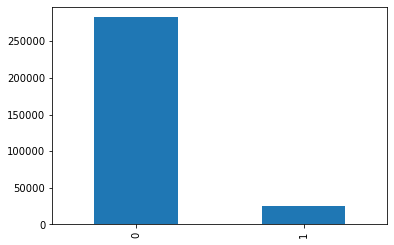

In [5]:
at_df['TARGET'].value_counts().plot(kind='bar')

#### Visualize a few features to get a feel for the data (in practice this should be more thorough)

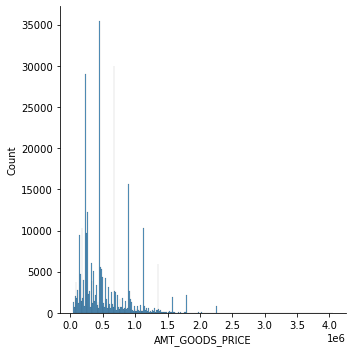

In [6]:
sns.displot(at_df["AMT_GOODS_PRICE"])

<AxesSubplot:xlabel='AMT_GOODS_PRICE', ylabel='DAYS_BIRTH'>

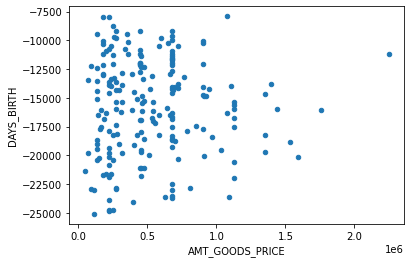

In [7]:
at_df.iloc[0:200].plot.scatter(x='AMT_GOODS_PRICE', y='DAYS_BIRTH')

<AxesSubplot:>

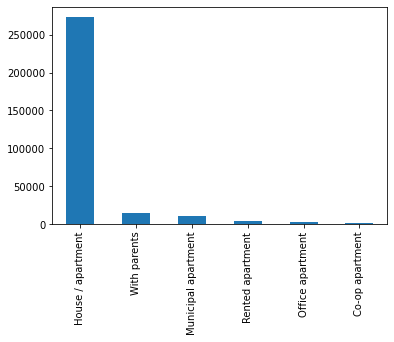

In [8]:
at_df['NAME_HOUSING_TYPE'].value_counts().plot(kind='bar')

#### Days counters are negative. Let's make them easier to interpret

In [9]:
at_df['DAYS_BIRTH'] = at_df['DAYS_BIRTH'] / -356
at_df['DAYS_EMPLOYED'] = at_df['DAYS_EMPLOYED'] / -356
at_df['DAYS_REGISTRATION'] = at_df['DAYS_REGISTRATION'] / -356
at_df['DAYS_ID_PUBLISH'] = at_df['DAYS_ID_PUBLISH'] / -356

at_df.rename(columns={'DAYS_BIRTH': 'YEARS_BIRTH',  'DAYS_EMPLOYED': 'YEARS_EMPLOYED', 'DAYS_REGISTRATION': 'YEARS_REGISTRAION', 'DAYS_ID_PUBLISH': 'YEARS_ID_PUBLISH'}, inplace=True)

at_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000,307511.000,307511.000,307511.000,307511.000,307499.000,307233.000,307511.000,307511.000,307511.000,...,307511.000,307511.000,307511.000,307511.000,265992.000,265992.000,265992.000,265992.000,265992.000,265992.000
mean,278180.519,0.081,0.417,168797.919,599026.000,27108.574,538396.207,0.021,45.048,-179.256,...,0.008,0.001,0.001,0.000,0.006,0.007,0.034,0.267,0.265,1.900
std,102790.175,0.272,0.722,237123.146,402490.777,14493.737,369446.461,0.014,12.258,396.842,...,0.090,0.024,0.023,0.018,0.084,0.111,0.205,0.916,0.794,1.869
min,100002.000,0.000,0.000,25650.000,45000.000,1615.500,40500.000,0.000,21.037,-1025.963,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,189145.500,0.000,0.000,112500.000,270000.000,16524.000,238500.000,0.010,34.868,0.812,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,278202.000,0.000,0.000,147150.000,513531.000,24903.000,450000.000,0.019,44.242,3.407,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,367142.500,0.000,1.000,202500.000,808650.000,34596.000,679500.000,0.029,55.287,7.753,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
max,456255.000,1.000,19.000,117000000.000,4050000.000,258025.500,4050000.000,0.073,70.868,50.315,...,1.000,1.000,1.000,1.000,4.000,9.000,8.000,27.000,261.000,25.000


## Bureau

In [10]:
b_df = pd.read_csv('bureau.csv')
bb_df = pd.read_csv('bureau_balance.csv')

bb_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


#### Extract more value from status column

In [11]:
bb_df['STATUS'].replace({'X': -2, 'C':-1}, inplace=True)
bb_df['STATUS'] = pd.to_numeric(bb_df['STATUS'])

#### We are dealing with time series of sorts so we should extract aggregates

<AxesSubplot:>

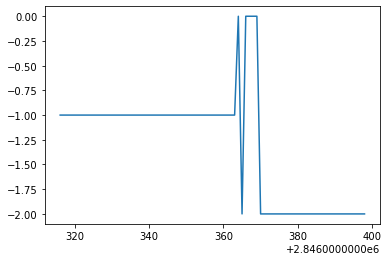

In [12]:
bb_df[bb_df['SK_ID_BUREAU'] == 5001710]['STATUS'].plot()

## Previous Applications

In [13]:
pa_df = pd.read_csv('Previous_Application.csv')

pa_df.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.000,1670214.000,1297979.000,1670214.000,1670213.000,774370.000,1284699.000,1670214.000,1670214.000,774370.000,...,5951.000,1670214.000,1670214.000,1297984.000,997149.000,997149.000,997149.000,997149.000,997149.000,997149.000
mean,1923089.135,278357.174,15955.121,175233.860,196114.021,6697.402,227847.279,12.484,0.996,0.080,...,0.774,-880.680,313.951,16.054,342209.855,13826.269,33767.774,76582.403,81992.344,0.333
std,532597.959,102814.824,14782.137,292779.762,318574.617,20921.495,315396.558,3.334,0.059,0.108,...,0.101,779.100,7127.443,14.567,88916.116,72444.870,106857.035,149647.415,153303.517,0.471
min,1000001.000,100001.000,0.000,0.000,0.000,-0.900,0.000,0.000,0.000,-0.000,...,0.373,-2922.000,-1.000,0.000,-2922.000,-2892.000,-2801.000,-2889.000,-2874.000,0.000
25%,1461857.250,189329.000,6321.780,18720.000,24160.500,0.000,50841.000,10.000,1.000,0.000,...,0.716,-1300.000,-1.000,6.000,365243.000,-1628.000,-1242.000,-1314.000,-1270.000,0.000
50%,1923110.500,278714.500,11250.000,71046.000,80541.000,1638.000,112320.000,12.000,1.000,0.052,...,0.835,-581.000,3.000,12.000,365243.000,-831.000,-361.000,-537.000,-499.000,0.000
75%,2384279.750,367514.000,20658.420,180360.000,216418.500,7740.000,234000.000,15.000,1.000,0.109,...,0.853,-280.000,82.000,24.000,365243.000,-411.000,129.000,-74.000,-44.000,1.000
max,2845382.000,456255.000,418058.145,6905160.000,6905160.000,3060045.000,6905160.000,23.000,1.000,1.000,...,1.000,-1.000,4000000.000,84.000,365243.000,365243.000,365243.000,365243.000,365243.000,1.000


## Credit Card Balance

In [14]:
ccb_df = pd.read_csv('credit_card_balance.csv')

ccb_df.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.000,3840312.000,3840312.000,3840312.000,3840312.000,3090496.000,3840312.000,3090496.000,3090496.000,3535076.000,...,3840312.000,3840312.000,3840312.000,3090496.000,3840312.000,3090496.000,3090496.000,3535076.000,3840312.000,3840312.000
mean,1904503.590,278324.207,-34.522,58300.155,153807.957,5961.325,7433.388,288.170,2968.805,3540.204,...,55965.877,58088.811,58098.285,0.309,0.703,0.005,0.559,20.825,9.284,0.332
std,536469.471,102704.475,26.668,106307.031,165145.700,28225.689,33846.077,8201.989,20796.887,5600.154,...,102533.617,105965.370,105971.801,1.100,3.190,0.083,3.241,20.051,97.516,21.479
min,1000018.000,100006.000,-96.000,-420250.185,0.000,-6827.310,-6211.620,0.000,0.000,0.000,...,-423305.820,-420250.185,-420250.185,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1434385.000,189517.000,-55.000,0.000,45000.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000
50%,1897122.000,278396.000,-28.000,0.000,112500.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15.000,0.000,0.000
75%,2369327.750,367580.000,-11.000,89046.686,180000.000,0.000,0.000,0.000,0.000,6633.911,...,85359.240,88899.491,88914.510,0.000,0.000,0.000,0.000,32.000,0.000,0.000
max,2843496.000,456250.000,-1.000,1505902.185,1350000.000,2115000.000,2287098.315,1529847.000,2239274.160,202882.005,...,1472316.795,1493338.185,1493338.185,51.000,165.000,12.000,165.000,120.000,3260.000,3260.000


## POS CASH

In [15]:
pcb_df = pd.read_csv('POS_CASH_balance.csv')

pcb_df.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,10001358.000,10001358.000,10001358.000,9975287.000,9975271.000,10001358.000,10001358.000
mean,1903216.599,278403.863,-35.013,17.090,10.484,11.607,0.654
std,535846.531,102763.745,26.067,11.995,11.109,132.714,32.762
min,1000001.000,100001.000,-96.000,1.000,0.000,0.000,0.000
25%,1434405.000,189550.000,-54.000,10.000,3.000,0.000,0.000
50%,1896565.000,278654.000,-28.000,12.000,7.000,0.000,0.000
75%,2368963.000,367429.000,-13.000,24.000,14.000,0.000,0.000
max,2843499.000,456255.000,-1.000,92.000,85.000,4231.000,3595.000


## Installments Payments

In [16]:
ip_df = pd.read_csv('installments_payments.csv')

ip_df.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,13605401.000,13605401.000,13605401.000,13605401.000,13605401.000,13602496.000,13605401.000,13602496.000
mean,1903364.970,278444.882,0.857,18.871,-1042.270,-1051.114,17050.907,17238.223
std,536202.906,102718.310,1.035,26.664,800.946,800.586,50570.254,54735.784
min,1000001.000,100001.000,0.000,1.000,-2922.000,-4921.000,0.000,0.000
25%,1434191.000,189639.000,0.000,4.000,-1654.000,-1662.000,4226.085,3398.265
50%,1896520.000,278685.000,1.000,8.000,-818.000,-827.000,8884.080,8125.515
75%,2369094.000,367530.000,1.000,19.000,-361.000,-370.000,16710.210,16108.425
max,2843499.000,456255.000,178.000,277.000,-1.000,-1.000,3771487.845,3771487.845


# Feature selection & engineering

## Bureau

#### Aggregate statistics for the month

In [17]:
bb_agg = bb_df.groupby('SK_ID_BUREAU')['STATUS'].agg(['mean', 'median', 'max', 'min', 'count'])

#### Merge the aggregates into the bureau dataframe

In [18]:
b_df = b_df.merge(bb_agg, on='SK_ID_BUREAU', how='left')

#### Separate numeric and categorical data and again compute aggregates

In [19]:
b_c = b_df.select_dtypes(exclude=[np.number])
b_c = pd.get_dummies(b_c)
b_c['SK_ID_CURR'] = b_df['SK_ID_CURR']

b_c = b_c.groupby('SK_ID_CURR').mean()
b_c = b_c[b_c.columns[(b_c.mean() > 0.001)]]

b_df = b_df.select_dtypes(include=[np.number])

b_agg = b_df.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR').agg(['mean', 'median', 'min', 'max', 'sum', 'count'])

#### Combine aggregates

In [20]:
b_agg.columns = b_agg.columns.to_flat_index()
b_agg = b_agg.merge(b_c, on='SK_ID_CURR', how='left')
b_agg.reset_index(inplace=True)
b_agg.columns = b_agg.columns.map(str)

## Previous applications

#### Drop columns with too many null values and then drop null rows (or seem useless intuitively)

In [21]:
pa_df.drop(columns=pa_df.columns[pa_df.isnull().sum() > 600000], axis=1, inplace=True)
pa_df.drop(columns=['NFLAG_LAST_APPL_IN_DAY'], inplace=True)

#### Separate categorical and numeic data

In [22]:
pa_c = pa_df.select_dtypes(exclude=[np.number])
pa_df = pa_df.select_dtypes(include=[np.number])

#### Get aggregate statistics

In [23]:
pa_agg = pa_df.drop(columns=['SK_ID_PREV']).groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'median', 'sum', 'count'])
pa_agg.columns = pa_agg.columns.to_flat_index()

pa_agg.rename(columns={'(SK_ID_CURR, )': 'SK_ID_CURR'}, inplace=True) 

pa_c = pd.get_dummies(pa_c)
pa_c['SK_ID_CURR'] = pa_df['SK_ID_CURR']
pa_c = pa_c.groupby('SK_ID_CURR').mean()
pa_c = pa_c[pa_c.columns[(pa_c.mean() > 0.1)]]

#### Combine aggregates

In [24]:
pa_agg = pa_agg.merge(pa_c, on='SK_ID_CURR', how='left')
pa_agg.columns = pa_agg.columns.map(str)

## Credit Card Balance

In [25]:
ccb_df.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)
ccb_agg = ccb_df.drop(columns=['SK_ID_PREV', 'MONTHS_BALANCE']).groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'median', 'sum', 'count'])
ccb_agg.columns = ccb_agg.columns.to_flat_index()

## POS CASH

In [26]:
pcb_agg = pcb_df.drop(columns=['MONTHS_BALANCE', 'NAME_CONTRACT_STATUS', 'SK_ID_PREV']).groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'median', 'sum', 'count'])
pcb_agg.columns = pcb_agg.columns.to_flat_index()

## Installments Payments

In [27]:
ip_agg = ip_df.drop(columns=['SK_ID_PREV']).groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'median', 'sum', 'count'])
ip_agg.columns = ip_agg.columns.to_flat_index()

#### Combine aggregates for previous applications

In [28]:
pa_agg = pa_agg.merge(ccb_agg, on='SK_ID_CURR', how='left')
pa_agg = pa_agg.merge(pcb_agg, on='SK_ID_CURR', how='left')
pa_agg = pa_agg.merge(ip_agg, on='SK_ID_CURR', how='left')

#### Merge all selected features into a single dataframe

In [29]:
selected = at_df.merge(pa_agg, on='SK_ID_CURR', how='left')
selected = selected.merge(b_agg, on='SK_ID_CURR', how='left')
selected.columns = selected.columns.map(str)
selected.shape

(307511, 474)

#### Create some additional variables that are likely to improve the model

In [30]:
selected['EXT_SOURCE_COMB1'] = selected['EXT_SOURCE_1'] * selected['EXT_SOURCE_2']
selected['EXT_SOURCE_COMB2'] = selected['EXT_SOURCE_1'] * selected['EXT_SOURCE_3']
selected['EXT_SOURCE_COMB3'] = selected['EXT_SOURCE_2'] * selected['EXT_SOURCE_3']
selected['EXT_SOURCE_1_SQR'] = selected['EXT_SOURCE_1'] * selected['EXT_SOURCE_1']
selected['EXT_SOURCE_2_SQR'] = selected['EXT_SOURCE_2'] * selected['EXT_SOURCE_2']
selected['EXT_SOURCE_3_SQR'] = selected['EXT_SOURCE_3'] * selected['EXT_SOURCE_3']

selected['CREDIT_OVER_INCOME'] = selected['AMT_CREDIT'] / selected['AMT_INCOME_TOTAL']
selected['AGE_OVER_CHILDREN'] = selected['YEARS_BIRTH'] / (1 + selected['CNT_CHILDREN'])
selected['CREDIT_LENGTH'] = selected['AMT_ANNUITY'] * selected['AMT_CREDIT']
selected['STABILITY'] = selected['YEARS_EMPLOYED'] * selected['REGION_RATING_CLIENT']

#### Drop rows with excessive null values

In [31]:
selected = selected[selected.isnull().sum(axis=1) < selected.isnull().sum(axis=1).mean() * 0.75]

#### Check feature correlations with target

In [32]:
cors = selected.corr()

tcors = cors['TARGET']
tcors.fillna(0, inplace=True)

tcors

SK_ID_CURR           -0.004
TARGET                1.000
CNT_CHILDREN          0.019
AMT_INCOME_TOTAL     -0.017
AMT_CREDIT           -0.037
                      ...  
EXT_SOURCE_3_SQR     -0.163
CREDIT_OVER_INCOME   -0.020
AGE_OVER_CHILDREN    -0.051
CREDIT_LENGTH        -0.040
STABILITY             0.034
Name: TARGET, Length: 469, dtype: float64

#### Split into train and test sets

In [33]:
labels = selected['TARGET']
ids = selected['SK_ID_CURR']

selected.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)

trainX, testX, trainY, testY = train_test_split(selected, labels, test_size=0.25, shuffle=True)

#### Separate numeric and categorical data

In [34]:
trainXn = trainX.select_dtypes(include=[np.number])
trainXc = trainX.select_dtypes(exclude=[np.number])

testXn = testX.select_dtypes(include=[np.number])
testXc = testX.select_dtypes(exclude=[np.number])

#### Check memory use and collect garbage

In [35]:
mem_check = False
if mem_check:
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

In [36]:
d = True
if d:
    del [[at_df, b_df, bb_df, pa_df, ccb_df, pcb_df, ip_df, bb_agg, b_agg, pa_agg, ccb_agg, pcb_agg, ip_agg, b_c, pa_c, selected, labels]]
    gc.collect()
    at_df = pd.DataFrame()
    b_df = pd.DataFrame()
    ccb_df = pd.DataFrame()
    b_c = pd.DataFrame()
    pa_c = pd.DataFrame()
    pcb_df = pd.DataFrame()
    ip_df = pd.DataFrame()
    b_agg = pd.DataFrame()
    bb_df = pd.DataFrame()
    bb_agg = pd.DataFrame()
    pa_df = pd.DataFrame()
    pa_agg = pd.DataFrame()
    ccb_agg = pd.DataFrame()
    pcb_agg = pd.DataFrame()
    ip_agg = pd.DataFrame()
    selected = pd.DataFrame()

#### Impute missing null values

In [37]:
l = LinearRegression()
i_imputer = IterativeImputer(estimator=l, add_indicator=True, max_iter=5)

trainXn = pd.DataFrame(i_imputer.fit_transform(trainXn))
testXn = pd.DataFrame(i_imputer.transform(testXn))

C:\Users\muggs\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


#### Standardize the data

In [38]:
r_scaler = RobustScaler()

trainXn = pd.DataFrame(r_scaler.fit_transform(trainXn))
testXn = pd.DataFrame(r_scaler.transform(testXn))

#### Deploy weight of evidence encoding  to assign numeric values to categorical data

In [39]:
woe = WOEEncoder()

trainXc = woe.fit_transform(trainXc, trainY)
testXc = woe.transform(testXc)

C:\Users\muggs\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [40]:
s_imputer = SimpleImputer(strategy='median', add_indicator=True)

trainXc = pd.DataFrame(s_imputer.fit_transform(trainXc))
testXc = pd.DataFrame(s_imputer.transform(testXc))

In [41]:
new_cols = []
for i in range(len(testXc.columns)):
    new_cols.append(str(trainXc.columns[i] + trainXn.shape[1]))

trainXc.columns = new_cols
testXc.columns = new_cols

#### Combine processed data to obtain features

In [42]:
frames = [trainXn.reset_index(drop=True), trainXc.reset_index(drop=True)]
trainX = pd.concat(frames, axis=1)

frames = [testXn.reset_index(drop=True), testXc.reset_index(drop=True)]
testX = pd.concat(frames, axis=1)

In [43]:
trainX.head()

,0,1,2,3,4,5,6,7,8,9,...,654,655,656,657,658,659,660,661,662,663
0,0.000,0.400,-0.557,-0.328,-0.552,0.341,0.783,-0.386,-0.456,-0.477,...,0.162,-0.373,0.093,-0.151,0.250,0.002,0.105,0.128,0.124,0.140
1,1.000,-0.400,1.129,0.456,1.219,0.915,-0.351,-0.036,-0.032,0.438,...,0.162,0.096,-0.031,-0.030,0.364,0.019,-0.167,0.128,0.124,0.140
2,0.000,-0.800,-0.606,-0.440,-0.604,-0.463,0.558,-0.400,1.176,-0.164,...,-0.096,-0.373,0.093,-0.030,0.222,0.019,0.160,0.128,0.124,0.140
3,0.000,-0.800,-0.787,-1.124,-0.760,-0.426,0.648,1.492,0.102,0.062,...,0.162,0.096,0.200,-0.030,-0.108,0.002,0.105,-0.144,-0.058,-0.141
4,0.000,-0.400,-0.536,-0.821,-0.542,0.000,0.544,-140.502,0.613,-0.703,...,-0.403,0.096,-0.031,-0.030,-0.233,0.057,-0.403,-0.144,-0.233,-0.141


# Model selection & parameter optimization 

In [44]:
del [[trainXn, trainXc, testXn, testXc]]
gc.collect()
trainXn = pd.DataFrame()
trainXc = pd.DataFrame()
testXn = pd.DataFrame()
testXc = pd.DataFrame()

#### Use a genetic algorithm to determine most appropriate model and hyperparameters for the model

In [45]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
tpot_clf = TPOTClassifier(generations=250, population_size=12, verbosity=2, scoring='f1', warm_start=True, n_jobs=-1)

In [61]:
tpot_clf.fit(trainX, trainY)
tpot_score = tpot_clf.score(testX, testY)

Optimization Progress:   0%|          | 0/3012 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.31334388842463423

Generation 2 - Current best internal CV score: 0.31334388842463423

Generation 3 - Current best internal CV score: 0.31334388842463423

Generation 4 - Current best internal CV score: 0.31334388842463423

Generation 5 - Current best internal CV score: 0.31334388842463423

Generation 6 - Current best internal CV score: 0.31334388842463423

Generation 7 - Current best internal CV score: 0.31334388842463423

Generation 8 - Current best internal CV score: 0.31334388842463423

Generation 9 - Current best internal CV score: 0.31334388842463423

Generation 10 - Current best internal CV score: 0.31334388842463423

Generation 11 - Current best internal CV score: 0.31334388842463423

Generation 12 - Current best internal CV score: 0.31334388842463423

Generation 13 - Current best internal CV score: 0.31334388842463423

Generation 14 - Current best internal CV score: 0.31334388842463423

Generation 15 - Current best internal CV s


Generation 120 - Current best internal CV score: 0.31334388842463423

Generation 121 - Current best internal CV score: 0.31334388842463423

Generation 122 - Current best internal CV score: 0.31334388842463423

Generation 123 - Current best internal CV score: 0.31334388842463423

Generation 124 - Current best internal CV score: 0.3139315726169095

Generation 125 - Current best internal CV score: 0.3139315726169095

Generation 126 - Current best internal CV score: 0.3139315726169095

Generation 127 - Current best internal CV score: 0.3139315726169095

Generation 128 - Current best internal CV score: 0.3139315726169095

Generation 129 - Current best internal CV score: 0.3139315726169095

Generation 130 - Current best internal CV score: 0.3139315726169095

Generation 131 - Current best internal CV score: 0.3139315726169095

Generation 132 - Current best internal CV score: 0.3139315726169095

Generation 133 - Current best internal CV score: 0.3139315726169095

Generation 134 - Current best


Best pipeline: GaussianNB(SelectPercentile(LinearSVC(RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.05, min_samples_leaf=20, min_samples_split=14, n_estimators=100), C=0.01, dual=False, loss=squared_hinge, penalty=l2, tol=0.1), percentile=1))


In [62]:
try:
    probs = tpot_clf.predict_proba(testX)
    preds = probs.argmax(axis=1)
except:
    preds = tpot_clf.predict(testX)

In [63]:
tpot_clf.export('tpot')

# Results

In [64]:
tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()

B = 1 - testY.sum()/testY.count()
accuracy = (tn + tp) / (tn + fp + tp + fn + 0.0001)
precision = tp / (tp + fp + 0.0001)
recall = tp / (tp + fn + 0.0001)
f1 = (1 + B ** 2) * (precision * recall) / (B ** 2 * precision + recall + 0.0001)
print(accuracy, precision, recall, f1)

0.8500268338699579 0.26444262553121944 0.39731048916195055 0.3117494121421445


Text(33.0, 0.5, 'Actual')

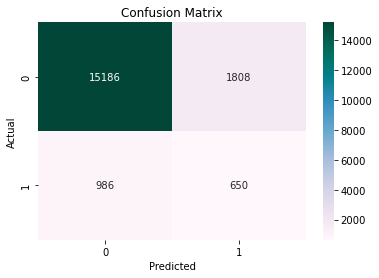

In [65]:
cm = confusion_matrix(testY, preds)
ax = sns.heatmap(cm, annot=True, cmap="PuBuGn", fmt='g')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

Text(0, 0.5, 'True Positive Rate')

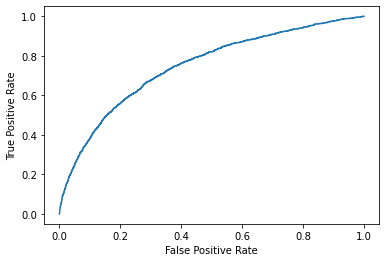

In [66]:
fpr, tpr, thresholds = roc_curve(testY, probs[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [67]:
roc_auc_score(testY, probs[:, 1])

0.7463877118430697

In [68]:
pd.set_option("display.max_rows", None, "display.max_columns", None)